# PUBG Analysis
## Big Data Solution
Jacey Hung, Ying Huang, Kai Li

In [1]:
#spark sql imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [4]:
spark = SparkSession.builder.appName('PUBG').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '16g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])
# the 4g is the total mun of the memory 4g * 4 executor = 16g


#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.driver.port', '38963'),
 ('spark.ui.proxyBase', '/proxy/application_1583779484394_0001'),
 ('spark.app.id', 'application_1583779484394_0001'),
 ('spark.yarn.historyServer.address', 'cluster-6ef3-m:18080'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.cores.max', '4'),
 ('spark.executor.cores', '4'),
 ('spark.driver.appUIAddress',
  'http://cluster-6ef3-m.c.bd-pubg.internal:4040'),
 ('spark.executor.memory', '16g'),
 ('spark.executorEnv.PYTHONPATH',
  '{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip'),
 ('spark.executor.instances', '2'),
 ('spark.driver.memory', '8g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webprox

In [5]:
spark.sparkContext

<SparkContext master=yarn appName=PUBG>

## Load Data

In aggregate, each match's meta information and player statistics are summarized (as provided by pubg). It includes various aggregate statistics such as player kills, damage, distance walked, etc as well as metadata on the match itself such as queue size, fpp/tpp, date, etc.

In [5]:
%%time

agg0 = spark.read.csv('gs://data-pubg/data/agg_match_stats_0.csv', inferSchema=True, header=True)
agg1 = spark.read.csv('gs://data-pubg/data/agg_match_stats_1.csv', inferSchema=True, header=True)
agg2 = spark.read.csv('gs://data-pubg/data/agg_match_stats_2.csv', inferSchema=True, header=True)
agg3 = spark.read.csv('gs://data-pubg/data/agg_match_stats_3.csv', inferSchema=True, header=True)
agg4 = spark.read.csv('gs://data-pubg/data/agg_match_stats_4.csv', inferSchema=True, header=True)
match = agg0.union(agg1)
match = match.union(agg2)
match = match.union(agg3)
match = match.union(agg4)


CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 1min 27s


In [7]:
match.printSchema()

root
 |-- date: string (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_placement: integer (nullable = true)



In [ ]:
%time match.show(5)

+--------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|                date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+--------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|          2870.724|        1784.84778|       117|           1|   SnuffIes|            1106.32|      4|            18|
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|2938.4072300000003

In deaths, the files record every death that occurred within the 720k matches. That is, each row documents an event where a player has died in the match.

In [6]:
%%time

kil0 = spark.read.csv('gs://data-pubg/data/kill_match_stats_final_0.csv', inferSchema=True, header=True)
kil1 = spark.read.csv('gs://data-pubg/data/kill_match_stats_final_1.csv', inferSchema=True, header=True)
kil2 = spark.read.csv('gs://data-pubg/data/kill_match_stats_final_2.csv', inferSchema=True, header=True)
kil3 = spark.read.csv('gs://data-pubg/data/kill_match_stats_final_3.csv', inferSchema=True, header=True)
kil4 = spark.read.csv('gs://data-pubg/data/kill_match_stats_final_4.csv', inferSchema=True, header=True)
kill = kil0.union(kil1)
kill = kill.union(kil2)
kill = kill.union(kil3)
kill = kill.union(kil4)


CPU times: user 16.2 ms, sys: 7.4 ms, total: 23.7 ms
Wall time: 1min 5s


In [9]:
kill.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: double (nullable = true)
 |-- killer_position_x: double (nullable = true)
 |-- killer_position_y: double (nullable = true)
 |-- map: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: double (nullable = true)
 |-- victim_position_x: double (nullable = true)
 |-- victim_position_y: double (nullable = true)



In [ ]:
kill.show(5)

+------------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|   killed_by|     killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|    victim_name|victim_placement|victim_position_x|victim_position_y|
+------------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|     Grenade| KrazyPortuguese|             5.0|         657725.1|         146275.2|MIRAMAR|2U4GBNA0YmnLSqvEy...| 823|KrazyPortuguese|             5.0|         657725.1|         146275.2|
|      SCAR-L|nide2Bxiaojiejie|            31.0|         93091.37|         722236.4|MIRAMAR|2U4GBNA0YmnLSqvEy...| 194|    X3evolution|            33.0|         92238.68|         723375.1|
|        S686|        Ascholes|            43.0|         366

#### Since we want to analyze the game time, we want to transform the date format first.

In [33]:
match.select('date').take(4)

[Row(date='2017-11-26T20:59:40+0000'),
 Row(date='2017-11-26T20:59:40+0000'),
 Row(date='2017-11-26T20:59:40+0000'),
 Row(date='2017-11-26T20:59:40+0000')]

In [7]:
match = match.withColumn("date", F.unix_timestamp(match["date"], "yyyy-MM-dd'T'HH:mm:ss'+0000'").cast('timestamp'))

In [8]:
from pyspark.sql.functions import *

match = match.withColumn('month', month(match['date']))
match = match.withColumn('year', year(match['date']))
match = match.withColumn('hour', hour(match['date']))
match = match.withColumn('dayOfWeek', dayofweek(match['date']))

In [ ]:
match.show(3)

+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+-----+----+----+---------+
|               date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|month|year|hour|dayOfWeek|
+-------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+-----+----+----+---------+
|2017-11-26 20:59:40|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|          2870.724|        1784.84778|       117|           1|   SnuffIes|            1106.32|      4|            18|   11|2017|  20|        1|
|2017-11-26 20:59:40

#### Also, match id is a long string combined with alphabet and numbers, we want to change it into short numeric numbers
We did this by using monotonically increasing id, and joined the numeric id with both dataset.

In [9]:
%%time
#replace match_id with numeric id
match_id = match.select('match_id').distinct()
match_id_kill = kill.select('match_id').distinct()
ids = match_id.union(match_id_kill).drop_duplicates(subset=['match_id'])
ids = ids.withColumn('id',F.monotonically_increasing_id())
match = match.join(ids, on=['match_id'],how = 'left').drop('match_id')
kill = kill.join(ids, on=['match_id'],how = 'left').drop('match_id')

CPU times: user 9.68 ms, sys: 1.99 ms, total: 11.7 ms
Wall time: 321 ms


In [ ]:
%time match.show(5)

+-------------------+---------+----------+----------+--------------+-----------+----------------+------------------+----------+------------+-----------+-------------------+-------+--------------+-----+----+----+---------+---+
|               date|game_size|match_mode|party_size|player_assists|player_dbno|player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|month|year|hour|dayOfWeek| id|
+-------------------+---------+----------+----------+--------------+-----------+----------------+------------------+----------+------------+-----------+-------------------+-------+--------------+-----+----+----+---------+---+
|2017-12-31 00:09:52|       92|       tpp|         1|             0|          0|             0.0|          1436.971|       200|           2|  A-mad-guy|  806.2130000000001| 100004|            35|   12|2017|   0|        1|880|
|2017-12-31 00:09:52|       92|       tpp|         1|             0|          0|             0.0

In [ ]:
%time kill.show(5)

+---------+----------------+----------------+-----------------+-----------------+-------+----+-------------+----------------+-----------------+-----------------+----+
|killed_by|     killer_name|killer_placement|killer_position_x|killer_position_y|    map|time|  victim_name|victim_placement|victim_position_x|victim_position_y|  id|
+---------+----------------+----------------+-----------------+-----------------+-------+----+-------------+----------------+-----------------+-----------------+----+
|     M416|2ezMannydazombie|            36.0|         360823.3|         394763.8|ERANGEL| 528|Maximus-Vegas|            49.0|         361327.9|         394764.3|1944|
|      SKS|        shihjhit|             1.0|         437294.3|         607006.1|ERANGEL|1549|      canti45|             8.0|         454747.8|         614544.0|1944|
|      SKS|        shihjhit|             1.0|         447843.3|         631740.4|ERANGEL| 435| LemonDropKid|            50.0|         437639.6|         623220.7|1944

## EDA
#### Add killing distance to kill

In [10]:
kill = kill.withColumn('kill_distance',F.sqrt((kill.killer_position_x-kill.victim_position_x)**2+
                                      (kill.killer_position_y-kill.victim_position_y)**2))
#kill.show(5)

In [38]:
%time kill_dis = kill.sample(withReplacement = False, fraction = 0.0001, seed=0).select('kill_distance','map','time').\
            dropna().toPandas()

CPU times: user 60.6 ms, sys: 6.04 ms, total: 66.7 ms
Wall time: 2min 29s


In [39]:
kill_dis.describe()

,kill_distance,time
count,5931.000000,5931.000000
mean,20600.819087,734.013657
std,100307.206030,552.583950
min,0.000000,65.000000
25%,504.196981,234.000000
50%,1741.459402,559.000000
75%,5842.036199,1199.500000
max,883842.451449,2017.000000


With the map shape 8km * 8km, we surprisingly found the median(50%）of the killing distance is only 1741. That means players usually fight closely or they are not good at long distance aiming. 

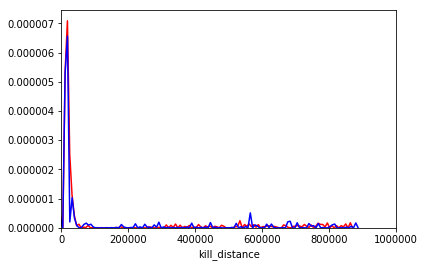

In [40]:
plt.xlim(-0.1, 1000000)
sns.distplot(kill_dis[kill_dis['map'] == 'ERANGEL']['kill_distance'],hist=False, color = 'r')
sns.distplot(kill_dis[kill_dis['map'] == 'MIRAMAR']['kill_distance'],hist=False, color = 'b')


The killing distance distribution also confirmed with the data summary.

### Mapping map into match

In [41]:
match_map=kill.select(['map','id']).distinct()

In [60]:
%time match_map.show(3)

+-------+----+
|    map|  id|
+-------+----+
|ERANGEL|2603|
|ERANGEL|3343|
|ERANGEL|1657|
+-------+----+
only showing top 3 rows

CPU times: user 25.5 ms, sys: 6.49 ms, total: 32 ms
Wall time: 2min 54s


In [42]:
match_joined = match.join(match_map, on = ['id'], how = 'left')

In [ ]:
match_joined.show(3)

+---+-------------------+---------+----------+----------+--------------+-----------+------------------+----------------+----------+------------+----------------+-------------------+-------+--------------+-----+----+----+---------+-------+
| id|               date|game_size|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|player_dist_walk|player_dmg|player_kills|     player_name|player_survive_time|team_id|team_placement|month|year|hour|dayOfWeek|    map|
+---+-------------------+---------+----------+----------+--------------+-----------+------------------+----------------+----------+------------+----------------+-------------------+-------+--------------+-----+----+----+---------+-------+
| 26|2017-11-26 04:52:28|       27|       tpp|         4|             0|          1|        1184.08569|      534.113464|       100|           0|         willy24|            316.712|      1|            20|   11|2017|   4|        1|ERANGEL|
| 26|2017-11-26 04:52:28|       27|       tp

#### Count the info with map and party size

In [ ]:
match_joined.groupby('map','party_size').count().show()

+-------+----------+--------+
|    map|party_size|   count|
+-------+----------+--------+
|MIRAMAR|         1| 2264797|
|ERANGEL|         2|17408494|
|   null|         1|  260305|
|ERANGEL|         4|24915816|
|   null|         4|  738129|
|MIRAMAR|         4| 6067369|
|MIRAMAR|         2| 3693025|
|   null|         2|  506749|
|ERANGEL|         1|11514547|
+-------+----------+--------+



## Team Stats


#### Average distance walk/ride 


In [ ]:
match_joined.groupby('map','party_size').avg('player_dist_walk').orderBy('avg(player_dist_walk)', ascending =[0]).show()

In [ ]:
%time match_joined.groupby('map','party_size').avg('player_dist_ride').orderBy('avg(player_dist_ride)', ascending =[0]).show()

#### Team average statistics by party size
We average the survival time, kills, assistis, down but not outs, ride distance and walk distace, to have a more clear view of the team performance

In [97]:
p1 = match.filter(match.party_size == 1).groupby(['id','team_id']).\
     agg(F.avg('party_size').alias('party_size'),F.avg('player_survive_time').alias('avg_survive_time'),\
         F.sum('player_kills').alias('total_kill'),F.sum('player_assists').alias('total_assists'),\
         F.sum('player_dbno').alias('total_dbno'),\
         F.avg('player_dist_ride').alias('avg_ride_dist'), F.avg('player_dist_walk').alias('avg_walk_dist'),\
         F.avg('team_placement').alias('placement'))

In [ ]:
p1stats = p1.summary().toPandas()

In [106]:
#!pip install gcsfs

In [105]:
p1stats.to_csv('gs://data-pubg/data/p1stats.csv')
p2stats.to_csv('gs://data-pubg/data/p2stats.csv')
p4stats.to_csv('gs://data-pubg/data/p4stats.csv')

In [ ]:
p2stats = p2.summary().toPandas()

In [ ]:
p2stats.head()

In [ ]:
p4stats.head()

,summary,id,team_id,party_size,avg_survive_time,total_kill,total_assists,total_dbno,avg_ride_dist,avg_walk_dist,placement
0,count,9192801,9192801,9192801,9192801,9192801,9192801,9192801,9192801,9192801,9192801
1,mean,8.545160898586636E11,14.516075894604919,4.0,19280.69214991141,3.022573859697387,1.0653548358111962,2.902959065468729,1254.4732931307217,1340.551085478132,14.313490306164574
2,stddev,4.9608193338959705E11,8.099261724309475,0.0,2.653018658968685E7,3.4693467682150634,1.678260694863076,2.837001165913618,1811.653150316133,2234.657033863011,8.050018504247115
3,min,0,1,4.0,0.0,0,0,0,0.0,0.0,0.0
4,25%,420906798500,8,4.0,330.60175,0,0,1,0.0,326.61064925,7.0


In [ ]:
match.filter(match.party_size == 4).groupby(['id','team_id']).\
    agg(F.avg('party_size'),F.avg('player_survive_time'),F.sum('player_kills'),F.avg('team_placement'),\
        F.avg('player_dist_ride'), F.avg('player_dist_walk')).\
    orderBy(['id','avg(player_survive_time)','avg(team_placement)'],ascending=[1,0,0]).show(5)

By Sorting the average survival time, and team placement, we find out some kind of relations between two, but not perfectly correlated. So we want to find out other features that determined the team placement. (Although later we find that max survival time of a team is the only determinator of the placement)

#### Survival time distribution by group-size

In [19]:
df1 = match.sample(withReplacement = False, fraction = 0.0001, seed=0).\
        join(kill.select('id','map'), match.id == kill.id, 'left').\
        select('player_survive_time','party_size','map').toPandas()

In [20]:
df1.shape

(599929, 3)

We sample 1/10000 data to convert to pandas, and to show the distribution.

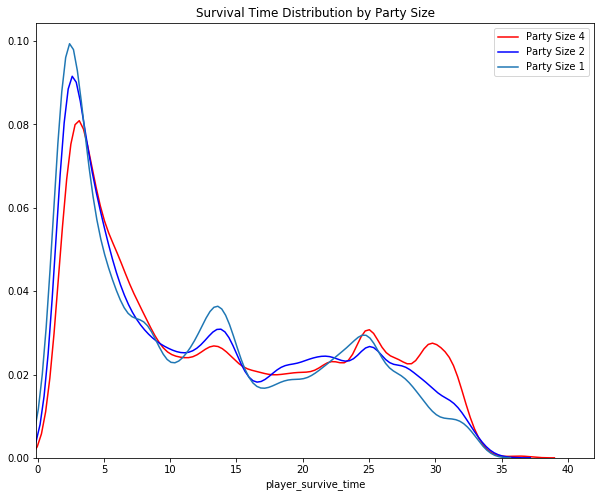

In [26]:
plt.figure(figsize=(10,8))
plt.xlim(-0.1, 42)
sns.distplot(df1[df1['party_size'] == 4]['player_survive_time']/60,hist=False, color = 'r',label='Party Size 4')
sns.distplot(df1[df1['party_size'] == 2]['player_survive_time']/60,hist=False, color = 'b',label='Party Size 2')
sns.distplot(df1[df1['party_size'] == 1]['player_survive_time']/60,hist=False,label='Party Size 1')
plt.title("Survival Time Distribution by Party Size")

plt.legend()
plt.show()

Here are things we found:
 - Most death happend at the beginning of the game
 - Solo game is fiercer at the early game than duo and squad
 - Peaks corresponding to the start of 2nd, 4th, and final Blue Zone (14 minutes, 25 minutes and 30 minutes) 

So we think it's may be a good idea to find the place that is much safer in the early game

#### Death position with in 4 minutes

In [4]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://storage.googleapis.com/data-pubg/data/miramar.jpg")
miramar_map = Image.open(BytesIO(response.content))

response2 = requests.get("https://storage.googleapis.com/data-pubg/data/erangel_1.jpg")
erangel_map = Image.open(BytesIO(response2.content))


In [23]:
erangel_map = erangel_map.resize((1000,1000))
erangel_map.width

1000

In [24]:
miramar_map.width

1000

In [46]:
#seperate two map
miramar = kill.filter(kill.map == 'MIRAMAR')
erangel = kill.filter(kill.map == 'ERANGEL')

In [47]:
db4_m = miramar.filter(miramar.time <= 240).select('victim_position_x','victim_position_y')

In [48]:
db4_m.count()

3023714

In [49]:
db4_m = db4_m.toPandas()

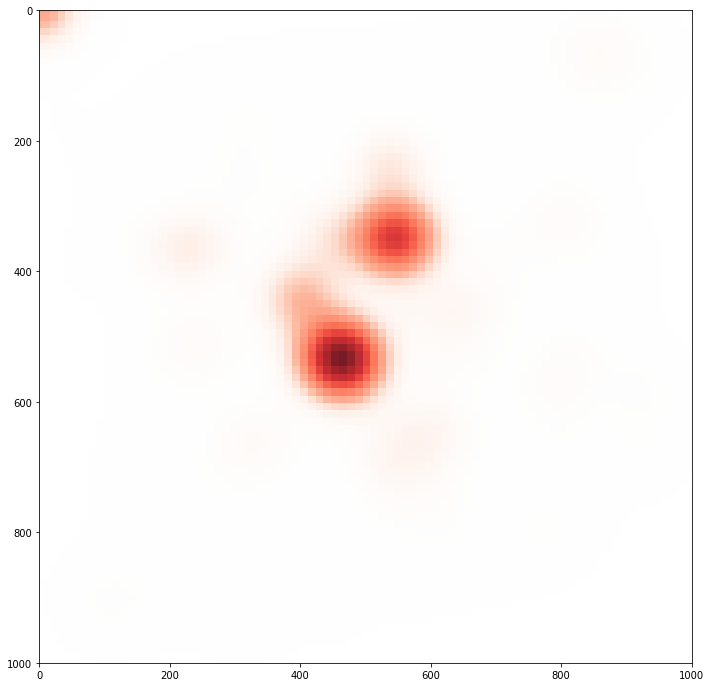

In [50]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np

def heatmap(x, y, s, bins=100):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

#bg = imread('../input/erangel.jpg')
hmap, extent = heatmap(db4_m['victim_position_x']/800, db4_m['victim_position_y']/800, 3.5) #parameter 4.5??
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*3.5, 0.0, 1.)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.Reds(colors)
colors[..., -1] = alphas

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000)
ax.imshow(miramar_map)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Reds, alpha=0.9)
#plt.scatter(plot_data_er[:,0], plot_data_er[:,1])
plt.gca().invert_yaxis()

#### Death position in a single match
Within a single match, we are able to show it as animation

In [ ]:
#miramar.select('match_id').distinct().show(5,truncate=False)

In [37]:
match1 = miramar.filter(miramar.id == 1677).\
        orderBy('time',ascending=[1]).toPandas()

<IPython.core.display.Javascript object>


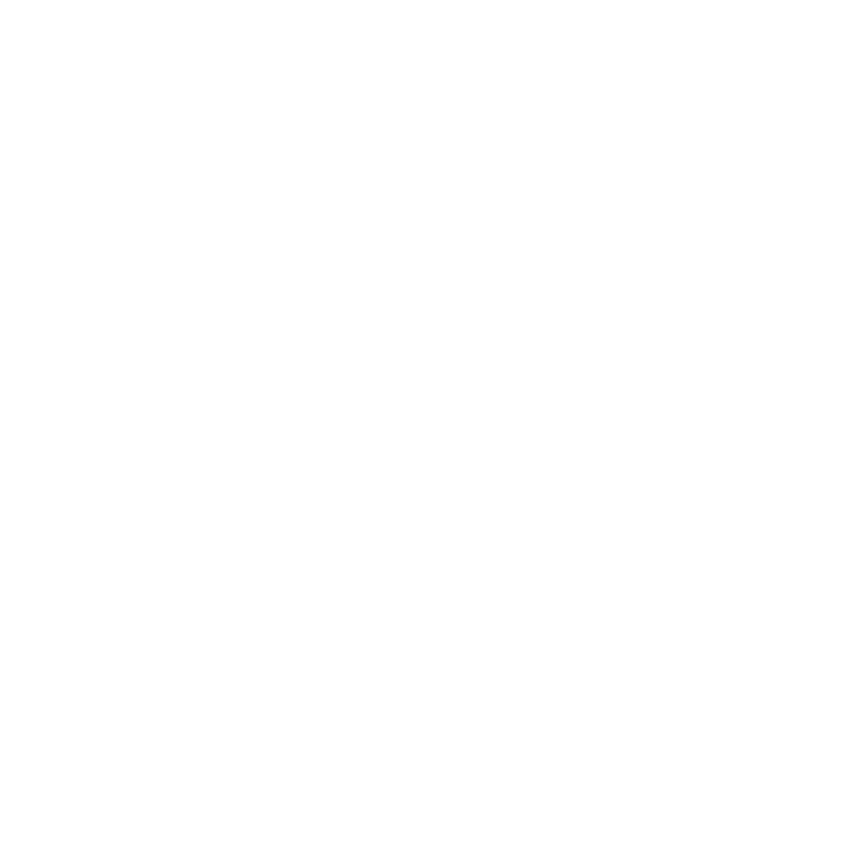

<IPython.core.display.Javascript object>


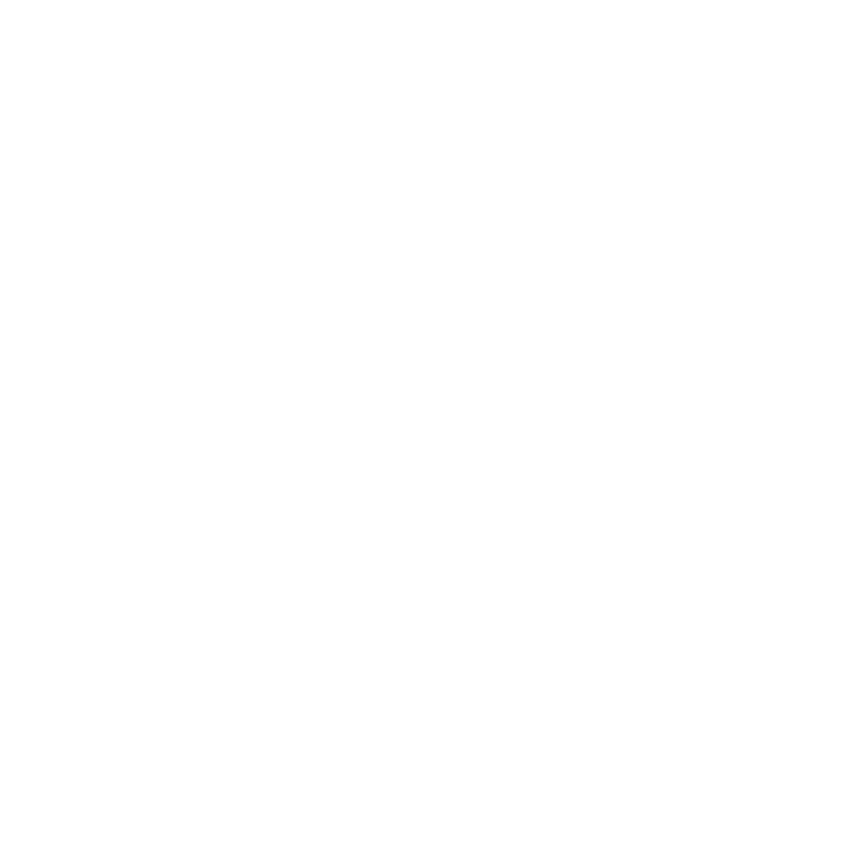

In [38]:
import matplotlib.animation as animation
%matplotlib notebook

#fig, ax = plt.subplots(figsize=(6,6))
#ax.set_xlim(0, 1000) 
#ax.set_ylim(1000,0)


fig = plt.figure(figsize=(6,6))
plt.xlim(0, 1000)
plt.ylim(1000, 0)

def animate(i):
    data = match1.iloc[:int(i+1),10:12]/800
    #sns.scatterplot(x='victim_position_x', y='victim_position_y', data=data, palette = "RdBu")
    plt.scatter(data['victim_position_x'],data['victim_position_y'],c='r',marker='x')
    
            
ani = animation.FuncAnimation(fig,animate,frames = match1.shape[0],repeat=False)
plt.imshow(miramar_map)
plt.show()

### Ranking Prediction

Every match, average survival time, total walking distance, total ride distance, total assists, total DBNO, total kills. 

And the relative placement 

In [39]:
match = match.withColumn('re_rank', F.col('team_placement')/F.col('game_size'))

In [41]:
p = match.groupby(['id','team_id']).\
     agg(F.avg('party_size').alias('party_size'),F.avg('player_survive_time').alias('avg_survive_time'),\
         F.sum('player_kills').alias('total_kill'),F.sum('player_assists').alias('total_assists'),\
         F.sum('player_dbno').alias('total_dbno'), F.sum('player_dmg').alias('total_damage'),\
         F.avg('player_dist_ride').alias('avg_ride_dist'), F.avg('player_dist_walk').alias('avg_walk_dist'),\
         F.avg('re_rank').alias('placement'))

In [42]:
train, test = p.select('id','team_id','party_size','avg_survive_time','total_kill','total_assists', 
                       'total_dbno','total_damage','avg_ride_dist','avg_walk_dist','placement').\
              randomSplit([0.8, 0.2], seed=12345)

In [ ]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Iterating over columns to be scaled
for i in ['avg_survive_time','total_kill','total_assists','total_dbno','total_damage','avg_ride_dist','avg_walk_dist']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # StandardScaler Transformation
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and StandardScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    pipeline = pipeline.fit(train)
    train = pipeline.transform(train).drop(i+"_Vect")
    test = pipeline.transform(test).drop(i+"_Vect")

CPU times: user 308 ms, sys: 87.9 ms, total: 396 ms
Wall time: 21min 14s


In [45]:
train.printSchema()

root
 |-- id: long (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- party_size: double (nullable = true)
 |-- avg_survive_time: double (nullable = true)
 |-- total_kill: long (nullable = true)
 |-- total_assists: long (nullable = true)
 |-- total_dbno: long (nullable = true)
 |-- total_damage: long (nullable = true)
 |-- avg_ride_dist: double (nullable = true)
 |-- avg_walk_dist: double (nullable = true)
 |-- placement: double (nullable = true)
 |-- avg_survive_time_Scaled: vector (nullable = true)
 |-- total_kill_Scaled: vector (nullable = true)
 |-- total_assists_Scaled: vector (nullable = true)
 |-- total_dbno_Scaled: vector (nullable = true)
 |-- total_damage_Scaled: vector (nullable = true)
 |-- avg_ride_dist_Scaled: vector (nullable = true)
 |-- avg_walk_dist_Scaled: vector (nullable = true)



In [46]:
test.printSchema()

root
 |-- id: long (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- party_size: double (nullable = true)
 |-- avg_survive_time: double (nullable = true)
 |-- total_kill: long (nullable = true)
 |-- total_assists: long (nullable = true)
 |-- total_dbno: long (nullable = true)
 |-- total_damage: long (nullable = true)
 |-- avg_ride_dist: double (nullable = true)
 |-- avg_walk_dist: double (nullable = true)
 |-- placement: double (nullable = true)
 |-- avg_survive_time_Scaled: vector (nullable = true)
 |-- total_kill_Scaled: vector (nullable = true)
 |-- total_assists_Scaled: vector (nullable = true)
 |-- total_dbno_Scaled: vector (nullable = true)
 |-- total_damage_Scaled: vector (nullable = true)
 |-- avg_ride_dist_Scaled: vector (nullable = true)
 |-- avg_walk_dist_Scaled: vector (nullable = true)



In [ ]:
%%time
tofeatures = VectorAssembler(inputCols = ['party_size','avg_survive_time_Scaled','total_kill_Scaled',\
                                          'total_assists_Scaled', 'total_dbno_Scaled','total_damage_Scaled',\
                                          'avg_ride_dist_Scaled','avg_walk_dist_Scaled'], \
                            outputCol = 'features')
train = tofeatures.transform(train)
test = tofeatures.transform(test)

CPU times: user 60.5 ms, sys: 11.2 ms, total: 71.7 ms
Wall time: 5min 34s


In [50]:
train = train.select('id','team_id','party_size','avg_survive_time_Scaled','total_kill_Scaled',\
                     'total_assists_Scaled', 'total_dbno_Scaled','total_damage_Scaled',\
                     'avg_ride_dist_Scaled','avg_walk_dist_Scaled','features','placement')
test = test.select('id','team_id','party_size','avg_survive_time_Scaled','total_kill_Scaled',\
                     'total_assists_Scaled', 'total_dbno_Scaled','total_damage_Scaled',\
                     'avg_ride_dist_Scaled','avg_walk_dist_Scaled','features','placement')

In [51]:
train.printSchema()
test.printSchema()

root
 |-- id: long (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- party_size: double (nullable = true)
 |-- avg_survive_time_Scaled: vector (nullable = true)
 |-- total_kill_Scaled: vector (nullable = true)
 |-- total_assists_Scaled: vector (nullable = true)
 |-- total_dbno_Scaled: vector (nullable = true)
 |-- total_damage_Scaled: vector (nullable = true)
 |-- avg_ride_dist_Scaled: vector (nullable = true)
 |-- avg_walk_dist_Scaled: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- placement: double (nullable = true)

root
 |-- id: long (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- party_size: double (nullable = true)
 |-- avg_survive_time_Scaled: vector (nullable = true)
 |-- total_kill_Scaled: vector (nullable = true)
 |-- total_assists_Scaled: vector (nullable = true)
 |-- total_dbno_Scaled: vector (nullable = true)
 |-- total_damage_Scaled: vector (nullable = true)
 |-- avg_ride_dist_Scaled: vector (nullable = true)
 |-- avg_wal

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='placement')
                      #maxIter=10, regParam=0.3, elasticNetParam=0.8)
%time lr = lr.fit(train)

CPU times: user 123 ms, sys: 43.8 ms, total: 167 ms
Wall time: 15min 43s


In [54]:
%%time
predict_lr = lr.transform(test)

CPU times: user 27 µs, sys: 8.45 ms, total: 8.48 ms
Wall time: 49.1 ms


In [55]:
print("Linear Regression training RMSE: %f" % lr.summary.rootMeanSquaredError)
print("Linear Regression training r2: %f" % lr.summary.r2)

Linear Regression training RMSE: 0.218069
Linear Regression training r2: 0.454778


In [56]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="placement")

In [57]:
print("Linear Regression r2 on test data = %g" % evaluator.evaluate(predict_lr,{evaluator.metricName: "r2"}))

Linear Regreesion r2 on test data = 0.458131


Linear Regression gives R2 around 0.45 on test set, which is not good. And this becomes our baseline

#### Random Forest

In [58]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol = 'placement')

In [ ]:
%%time
rf = rf.fit(train)

CPU times: user 77.5 ms, sys: 13 ms, total: 90.5 ms
Wall time: 7min 50s


In [67]:
%%time
predict_rf = rf.transform(test)

print("Random Forest R2 on test data = %g" % evaluator.evaluate(predict_rf,{evaluator.metricName: "r2"}))

Random Forest R2 on test data = 0.906374
CPU times: user 28 ms, sys: 8.14 ms, total: 36.1 ms
Wall time: 3min 2s


In [64]:
rf.featureImportances

SparseVector(8, {0: 0.0056, 1: 0.3974, 2: 0.0357, 3: 0.0005, 4: 0.0015, 5: 0.0324, 6: 0.1251, 7: 0.4019})

In [66]:
rf.getNumTrees

20

In [72]:
rf.totalNumNodes

1260

Surprisingly, using Random Forest with 20 trees and 1260 total nodes, the model is able to explain 90% percent of the variance of relative placement. It gives the average walking distance and average survival time the highest importances among all the features, with 0.4 each.

In [2]:
#%%time
#predict_lr.select("prediction", "placement", "features").show(10)

#### Gradient Boosting Trees

In [ ]:
%%time
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol = 'placement',maxIter=5)

gbt = gbt.fit(train)

CPU times: user 200 ms, sys: 90.4 ms, total: 290 ms
Wall time: 29min 1s


In [83]:
%%time
predict_gbt = gbt.transform(test)

print("GBT R2 on test data = %g" % evaluator.evaluate(predict_gbt,{evaluator.metricName: "r2"}))

GBT R2 on test data = 0.917593
CPU times: user 40.1 ms, sys: 13.2 ms, total: 53.3 ms
Wall time: 3min 32s


In [85]:
gbt.featureImportances

SparseVector(8, {0: 0.2181, 1: 0.2093, 2: 0.2248, 3: 0.037, 4: 0.0042, 5: 0.0079, 6: 0.0284, 7: 0.2702})

In [86]:
gbt.getNumTrees

5

With GBT, the model further improves to R2 = 0.92. More interestingly, the GBT gives different feature importance than RF. Still, average walk distance is the most important features with 0.27, followed by total kills and party size with 0.22 each, and then average survival time with 0.21. This makes more sense to us. 

We also try to predict only on the party size of 1 data, assuming this will be more robust since the placement is from 1 to 100. 

#### Predict just on party size 1

In [13]:
p1 = match.filter(match.party_size == 1).groupby(['id','team_id']).\
     agg(F.avg('party_size').alias('party_size'),F.avg('player_survive_time').alias('avg_survive_time'),\
         F.sum('player_kills').alias('total_kill'),F.sum('player_assists').alias('total_assists'),\
         F.sum('player_dbno').alias('total_dbno'),\
         F.avg('player_dist_ride').alias('avg_ride_dist'), F.avg('player_dist_walk').alias('avg_walk_dist'),\
         F.avg('team_placement').alias('placement'))

In [14]:
p1.count()

14039649

In [15]:
p1_train, p1_test = p1.select('id','team_id','party_size','avg_survive_time','total_kill','total_assists', 
                       'total_dbno','avg_ride_dist','avg_walk_dist','placement').\
              randomSplit([0.8, 0.2], seed=12345)

In [ ]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

for i in ['avg_survive_time','total_kill','total_assists','total_dbno','avg_ride_dist','avg_walk_dist']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    pipeline = pipeline.fit(p1_train)
    p1_train = pipeline.transform(p1_train).drop(i+"_Vect")
    p1_test = pipeline.transform(p1_test).drop(i+"_Vect")

CPU times: user 227 ms, sys: 59.9 ms, total: 287 ms
Wall time: 13min 31s


In [28]:
%%time
tofeatures = VectorAssembler(inputCols = ['party_size','avg_survive_time_Scaled','total_kill_Scaled',\
                                          'total_assists_Scaled', 'total_dbno_Scaled',\
                                          'avg_ride_dist_Scaled','avg_walk_dist_Scaled'], \
                            outputCol = 'features')
p1_train = tofeatures.transform(p1_train)
p1_test = tofeatures.transform(p1_test)

CPU times: user 38.7 ms, sys: 16 ms, total: 54.8 ms
Wall time: 4min 23s


In [30]:
%%time
p1_train = p1_train.select('id','team_id','party_size','avg_survive_time_Scaled','total_kill_Scaled',\
                     'total_assists_Scaled', 'total_dbno_Scaled',\
                     'avg_ride_dist_Scaled','avg_walk_dist_Scaled','features','placement')
p1_test = p1_test.select('id','team_id','party_size','avg_survive_time_Scaled','total_kill_Scaled',\
                     'total_assists_Scaled', 'total_dbno_Scaled',\
                     'avg_ride_dist_Scaled','avg_walk_dist_Scaled','features','placement')

CPU times: user 12.9 ms, sys: 1.6 ms, total: 14.5 ms
Wall time: 54.2 ms


#### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='placement')
%time lr_1 = lr.fit(p1_train)

CPU times: user 85.3 ms, sys: 30.2 ms, total: 115 ms
Wall time: 9min 49s


In [ ]:
%%time
predict_lr1 = lr_1.transform(p1_test)
predict_lr1 = predict_lr1.withColumn('roundedPrediction', F.round(predict_lr1['prediction'],0))

CPU times: user 10.2 ms, sys: 3.55 ms, total: 13.8 ms
Wall time: 68 ms


In [35]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="roundedPrediction", \
                 labelCol="placement",metricName="rmse")

In [ ]:
%time print("Linear Regreesion RMSE on test data = %g" % evaluator.evaluate(predict_lr1))

Linear Regreesion RMSE on test data = 21.8082
CPU times: user 26.8 ms, sys: 5.16 ms, total: 31.9 ms
Wall time: 2min 21s


In [ ]:
print('Done')

Done


However, the result is not good, since by the game rules, even party size of 1 can play with other teams of party size of 2 or 4.

In [83]:
p1 = assembler.transform(p1)

In [93]:
p1_train, p1_test = p1.randomSplit([0.8, 0.2], seed=12345)

In [94]:
ss1 = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True).fit(p1_train)
p1_train = ss1.transform(p1_train)
p1_test = ss1.transform(p1_test)

In [ ]:
lr1 = lr.fit(p1_train)
print("RMSE: %f" % lr1.summary.rootMeanSquaredError)
print("r2: %f" % lr1.summary.r2)
p1_predict = lr1.transform(p1_test)
print("R Squared (R2) on party 2 test data = %g" % lr_evaluator.evaluate(p1_predict))

RMSE: 21.916141
r2: 0.358509
R Squared (R2) on test data = 0.354859


### Graph
Since we have killers, victims, and by match id and team id, we are also able to identify the teammates, we think it may be a good idea to put the players into graph based data, to find potential friends.

#### Following is how we set it up on GCP, and the result will be shown on other notebook.

In [104]:
#!pip install graphframes

In [138]:
from graphframes import *

In [139]:
!which pyspark

/opt/conda/anaconda/bin/pyspark


In [140]:
!echo ${SPARK_HOME}/jars

/usr/lib/spark/jars


In [134]:
!ls /usr/lib/spark/jars

accessors-smart-1.2.jar
activation-1.1.1.jar
aircompressor-0.10.jar
all-1.1.2.pom
antlr-2.7.7.jar
antlr4-runtime-4.7.jar
antlr-runtime-3.4.jar
aopalliance-1.0.jar
aopalliance-repackaged-2.4.0-b34.jar
apacheds-i18n-2.0.0-M15.jar
apacheds-kerberos-codec-2.0.0-M15.jar
apache-log4j-extras-1.2.17.jar
api-asn1-api-1.0.0-M20.jar
api-util-1.0.0-M20.jar
arpack_combined_all-0.1.jar
arrow-format-0.10.0.jar
arrow-memory-0.10.0.jar
arrow-vector-0.10.0.jar
audience-annotations-0.5.0.jar
automaton-1.11-8.jar
avro-1.8.2.jar
avro-ipc-1.8.2.jar
avro-mapred-1.8.2-hadoop2.jar
aws-java-sdk-bundle-1.11.199.jar
azure-keyvault-core-0.8.0.jar
azure-storage-5.4.0.jar
bonecp-0.8.0.RELEASE.jar
breeze_2.11-0.13.2.jar
breeze-macros_2.11-0.13.2.jar
calcite-avatica-1.2.0-incubating.jar
calcite-core-1.2.0-incubating.jar
calcite-linq4j-1.2.0-incubating.jar
chill_2.11-0.9.3.jar
chill-java-0.9.3.jar
commons-beanutils-1.9.4.jar
commons-cli-1.2.jar
commons-codec-1.10.jar
commons-collections-3.2.2.jar
commons-compiler-3.0.9

In [135]:
!wget http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.7.0-spark2.4-s_2.11/graphframes-0.7.0-spark2.4-s_2.11.jar

In [136]:
!cp /graphframes-0.7.0-spark2.4-s_2.11.jar /usr/lib/spark/jars

In [106]:
players = kill.withColumn("src", kill["killer_name"])
players = players.withColumn("dst", kill["victim_name"])

In [142]:
graph = GraphFrame(match, players)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:46583)
Traceback (most recent call last):
  File "/opt/conda/anaconda/lib/python3.6/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/anaconda/lib/python3.6/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:46583)